In [1]:
import pandas as pd
import numpy as np

purchasing = pd.read_csv('original_data/Purchasing_Tool_FY16-FY18_2018-11-16.csv')
expo = pd.read_csv('original_data/Expo_Archive_2018-11-16.csv')

print purchasing.columns
print expo.columns

Index([u'Supplier ID', u'PO', u'Line', u'Shipment', u'Release', u'StdCost',
       u'PoCost', u'BuyerNumber', u'BuyProgram', u'BuyerName', u'Part',
       u'Description', u'Qty', u'ReceiverNumber', u'SupplierID', u'Year',
       u'Period', u'Week', u'Qtr', u'CommodityLevel1', u'CommodityLevel2',
       u'CommodityLevel3', u'InternalCostSavings', u'Spend', u'ForecastType',
       u'PurchLeadTime', u'ABC', u'PaymentTerm', u'SupplierClassification',
       u'Category', u'PoPlacedDate', u'PoPlacedYear', u'Org_Code',
       u'SupplierSite'],
      dtype='object')
Index([u'Supplier ID', u'PO Number', u'Line', u'Schedule', u'Revision',
       u'Confirmed Dock Date', u'Part Number', u'Part Description',
       u'Part Revision', u'Performance Date', u'Supplier Due Date',
       u'Need Date', u'Order Date', u'Message', u'Qty Open', u'Unit Price',
       u'Extended Price', u'Critical', u'VMI', u'Date Modified', u'Comments',
       u'Harris Comments', u'Shipments', u'Business Unit Code'],
      dt

In [2]:
# save dataframe with part number and category

category = pd.DataFrame()

category['Part Number'] = purchasing['Part']
category['Category'] = purchasing['Category']

category = category.drop_duplicates(subset = ['Part Number'])
category = category.dropna()

In [3]:
# save dataframe with 'Supplier ID' and 'SupplierID'

supplier = pd.DataFrame()

supplier['Supplier ID'] = purchasing['Supplier ID']
supplier['SupplierID'] = purchasing['SupplierID']

In [4]:
# drop irrelevant features

purchasing = purchasing.drop(['SupplierID', 'Shipment', 'PO', 'Line', 'Release','BuyerNumber', 'BuyProgram', 'BuyerName', 'Description', 'ReceiverNumber',
                'Year', 'Period', 'Week', 'Qtr', 'CommodityLevel1', 'CommodityLevel2', 'CommodityLevel3',
                'ForecastType', 'PaymentTerm', 'SupplierClassification', 'PoPlacedDate', 'PoPlacedYear',
                'Org_Code', 'SupplierSite'], axis = 1)

expo = expo.drop(['Revision', 'Part Description', 'PO Number', 'Line', 'Schedule', 'Revision','Part Revision', 'Supplier Due Date', 'Message', 'Qty Open', 'Unit Price',
          'Extended Price', 'VMI', 'Date Modified', 'Comments', 'Harris Comments', 'Shipments', 'Business Unit Code']
         , axis =1)


In [5]:
# fix dates in expo

from datetime import datetime as dt
def convert_to_date(s):
    try: 
        return dt.date(dt.strptime(str(s)[:10], '%Y-%M-%d'))
    except (TypeError, ValueError) as e:
        return (pd.NaT)
    
def convert_to_date2(s):
    try:
        return dt.date(dt.strptime(str(s), '%m/%d/%Y'))
    except (TypeError, ValueError) as e:
        return (pd.NaT)
    
expo['Confirmed Dock Date'] = expo['Confirmed Dock Date'].apply(convert_to_date2)
expo['Performance Date'] = expo['Performance Date'].apply(convert_to_date)
expo['Need Date'] = expo['Need Date'].apply(convert_to_date)
expo['Order Date'] = expo['Order Date'].apply(convert_to_date)


In [6]:
# drop na in expo except in schedule

print expo.count()

expo = expo.dropna()
expo = expo.reset_index(drop = True)

Supplier ID            112819
Confirmed Dock Date     83646
Part Number             92442
Performance Date       113194
Need Date              109062
Order Date             113194
Critical               113194
dtype: int64


In [7]:
# engineer late and early columns in expo

expo['temp_Late'] =  expo['Performance Date'] - expo['Confirmed Dock Date']
expo['temp_Late'] = expo['temp_Late'].astype('timedelta64[D]')

expo['Late'] = [i if i > 0 else 0 for i in expo['temp_Late']]
expo['Early'] = [abs(i) if i < 0 else 0 for i in expo['temp_Late']]

del expo['temp_Late']

In [8]:
# drop nas from purchasing tool

print purchasing.count()

purchasing = purchasing.dropna()
purchasing = purchasing.reset_index(drop = True)

Supplier ID            135181
StdCost                135181
PoCost                 135181
Part                   132601
Qty                    135181
InternalCostSavings    135181
Spend                  135181
PurchLeadTime          135181
ABC                    131482
Category               135181
dtype: int64


In [9]:
# fix purchase lead time codes

purch_lead_time_dict = {240:183, 299:365 ,999:365, 365:274, 364:274, 350:274}
purchasing['PurchLeadTime'] = [purch_lead_time_dict[i] if i in purch_lead_time_dict.keys() else i for i in purchasing['PurchLeadTime']]

In [10]:
# create return spend and return quantity columns. Zero out negatives in spend  and qty
# transaction_type is 0 = return, 1 = order

purchasing['return'] = [1 if d < 0 else 0 for d in purchasing['Spend']]
# purchasing['transaction_type'] = [0 if d < 0 else 1 for d in purchasing['Spend']]

purchasing['Return_spend'] = [0 if d >= 0 else abs(d) for d in purchasing['Spend']]
# purchasing['Spend'] = [d if d >= 0 else 0 for d in purchasing['Spend']]
                       
purchasing['Return_qty'] = [0 if d >= 0 else abs(d) for d in purchasing['Qty']]
# purchasing['Qty'] = [d if d >= 0 else 0 for d in purchasing['Qty']]

In [11]:
# add single/multi source column to p_tool as 'Source'.

source = pd.DataFrame()

source['Source'] = purchasing.groupby(['Part'])['Supplier ID'].apply(lambda x: x.drop_duplicates().count())
#source['Source'] = [1 if (d == 1) else 0 for d in source['Source']]
source['Part'] = source.index
source.index = range(len(source))

purchasing = purchasing.merge(source, on = ['Part'], how = 'left')

In [12]:
# transform ABC column in purchasing

ABC_dict = {'A':0.7, 'B':0.5, 'C':0.3}
purchasing['ABC'] = [ABC_dict[d] for d in purchasing['ABC']]

In [13]:
# drop early/late outliers

expo = expo.drop(list(expo[expo['Late'] > 5000].index), axis = 0)
expo = expo.drop(list(expo[expo['Early'] > 5000].index), axis = 0)
expo = expo.reset_index(drop = True)

In [14]:
print purchasing.count()
print expo.count()

Supplier ID            131482
StdCost                131482
PoCost                 131482
Part                   131482
Qty                    131482
InternalCostSavings    131482
Spend                  131482
PurchLeadTime          131482
ABC                    131482
Category               131482
return                 131482
Return_spend           131482
Return_qty             131482
Source                 131482
dtype: int64
Supplier ID            72375
Confirmed Dock Date    72375
Part Number            72375
Performance Date       72375
Need Date              72375
Order Date             72375
Critical               72375
Late                   72375
Early                  72375
dtype: int64


In [15]:
#generate unexpected cost = PoCost/StdCost
purchasing['Unexp_Cost'] = np.nan
pd.to_numeric(purchasing['Unexp_Cost'], downcast='float')
# print(df2.dtypes)
# print(df2['newCritical'])
for i, row in purchasing.iterrows():
    if (purchasing['StdCost'][i] > 0):
        k = (purchasing['PoCost'][i] / purchasing['StdCost'][i])
    else:
        k = 1
    purchasing.set_value(i,'Unexp_Cost',k)
purchasing['Unexp_Cost']

0          0.921007
1          0.883122
2          1.000000
3          1.000000
4          1.000000
5          1.000000
6          3.208200
7          1.000000
8          1.000000
9          1.000000
10         1.000000
11         1.000000
12         3.671594
13         0.954545
14         0.909091
15         0.909091
16         0.909091
17        47.545455
18        40.727273
19         8.318182
20         1.000000
21         0.940952
22         1.000000
23         1.000000
24         1.000000
25         1.000000
26         1.000000
27         1.000000
28         1.166667
29         1.000000
            ...    
131452     1.000000
131453     1.000000
131454     1.000000
131455     1.000000
131456     1.000000
131457     1.652873
131458     1.651599
131459     1.441679
131460     1.010166
131461     0.884956
131462     1.047044
131463     1.000000
131464     1.000000
131465     0.986193
131466     0.979540
131467     1.000000
131468     1.000000
131469     1.230769
131470     1.097561


In [16]:
print purchasing['Unexp_Cost'].max()

4000.0


In [17]:
import matplotlib.pyplot as plt
import numpy as np
import math

# p_features = ['StdCost', 'PoCost', 'Qty',
#            'InternalCostSavings', 'Spend', 'PurchLeadTime', 'ABC',  
#             'transaction_type', 'Return_spend', 'Return_qty', 'Source']

# e_features = ['Late', 'Early', 'Critical']

# for feat in p_features:
#     plt.hist(purchasing[feat], bins = 15)
#     plt.title(feat)
#     plt.xlabel = ("Value")
#     plt.ylabel = ("Count")
#     #fname = "distr/" + feat + "_distr"
#     #plt.savefig(fname)
#     plt.show()
    
# for feat in e_features:
#     plt.hist(expo[feat], bins = 15)
#     plt.title(feat)
#     plt.xlabel = ("Value")
#     plt.ylabel = ("Count")
#     #fname = "distr/" + feat + "_distr"
#     #plt.savefig(fname)
#     plt.show()


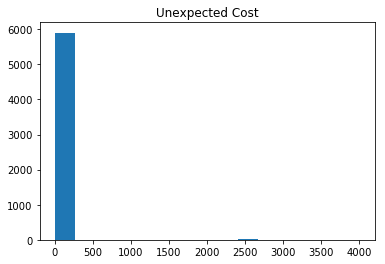

In [18]:
purchasing2 = purchasing.drop(list(purchasing[purchasing['Unexp_Cost'] < 2].index), axis = 0)

plt.hist(purchasing2['Unexp_Cost'], bins = 15)
plt.title('Unexpected Cost')
plt.xlabel = ("Value")
plt.ylabel = ("Count")
#fname = "distr/" + feat + "_distr"
#plt.savefig(fname)
plt.show()

In [19]:
#bins 

# purchasing
def bin_purchasing(d):
    data = d.copy()
    data['Unexp_Cost'] = pd.to_numeric(pd.cut(data['Unexp_Cost'], bins = [-1,.9999,1.0001,1.2,2,10000000], labels = [1,2,3,4,5]))
    data['StdCost'] = pd.to_numeric(pd.cut(data['StdCost'], bins = [-1,1,5,50,100,10000000], labels = [1,2,3,4,5]))
    data['PoCost'] = pd.to_numeric(pd.cut(data['PoCost'], bins = [-1,1,5,50,100,10000000], labels = [1,2,3,4,5]))
    data['Qty'] = pd.to_numeric(pd.cut(data['Qty'], bins = [-1,50,150,500,5000,10000000], labels = [1,2,3,4,5]))
    data['InternalCostSavings'] = pd.to_numeric(pd.cut(data['InternalCostSavings'], 
                                         bins = [-1000000,-100,-10,0,10,10000000], labels = [5,4,3,2,1]))
    data['Spend'] = pd.to_numeric(pd.cut(data['Spend'], bins = [-1,2500,10000,50000,100000,100000000], 
                                         labels = [1,2,3,4,5]))
    data['PurchLeadTime'] = pd.to_numeric(pd.cut(data['PurchLeadTime'], 
                                   bins = [-1,50,125,225,350,10000], labels = [1,2,3,4,5]))
    data['ABC'] = pd.to_numeric(pd.cut(data['ABC'], bins = [0,0.4,0.6,1], labels = [1,3,5]))
    data['return'] = pd.to_numeric(pd.cut(data['return'], bins = [-0.5,0.5,2], labels = [1,5]))
    data['Return_spend'] = pd.to_numeric(pd.cut(data['Return_spend'], 
                                                bins = [-1,2500,10000,50000,100000,100000000], labels = [1,2,3,4,5]))
    data['Return_qty'] = pd.to_numeric(pd.cut(data['Return_qty'], 
                                              bins = [-1,50,150,500,5000,10000000], labels = [1,2,3,4,5]))
    data['Source'] = pd.to_numeric(pd.cut(data['Source'], bins = [-1,1.1,3.1,10], labels = [5,2,1]))

    return data

def bin_expo(d):
    data = d.copy()
    data['Late_bin'] = pd.to_numeric(pd.cut(data['Late'], bins = [-1,0.5,3,10,20,1000], labels = [1,2,3,4,5]))
    data['Early_bin'] = pd.to_numeric(pd.cut(data['Early'], bins = [-1,0.5,3,10,20,1000], labels = [1,2,3,4,5]))
    return data

In [20]:
purch_binned = bin_purchasing(purchasing)
expo_binned = bin_expo(expo)

print purch_binned.count()
print expo_binned.count()

Supplier ID            131482
StdCost                131482
PoCost                 131482
Part                   131482
Qty                    128438
InternalCostSavings    131482
Spend                  128456
PurchLeadTime          131482
ABC                    131482
Category               131482
return                 131482
Return_spend           131482
Return_qty             131482
Source                 131482
Unexp_Cost             131482
dtype: int64
Supplier ID            72375
Confirmed Dock Date    72375
Part Number            72375
Performance Date       72375
Need Date              72375
Order Date             72375
Critical               72375
Late                   72375
Early                  72375
Late_bin               72369
Early_bin              72368
dtype: int64


In [21]:
# aggregate purchasing


def purchasing_aggregate(data, groupby):
    aggregate = pd.DataFrame()
    
    aggregate['mean_unexpcost'] = data.groupby(groupby)['Unexp_Cost'].mean()
    aggregate['median_unexpcost'] = data.groupby(groupby)['Unexp_Cost'].median()
    #aggregate['var_log_qty'] = data.groupby(groupby)['Qty'].var()
    
    aggregate['mean_return'] = data.groupby(groupby)['return'].mean()
    aggregate['median_return'] = data.groupby(groupby)['return'].median()
    #aggregate['var_log_qty'] = data.groupby(groupby)['Qty'].var()
    
    aggregate['mean_stdcost'] = data.groupby(groupby)['StdCost'].mean()
    aggregate['median_stdcost'] = data.groupby(groupby)['StdCost'].median()
    #aggregate['var_stdcost'] = data.groupby(groupby)['StdCost'].var()

    aggregate['mean_pocost'] = data.groupby(groupby)['PoCost'].mean()
    aggregate['median_pocost'] = data.groupby(groupby)['PoCost'].median()
    #aggregate['var_log_pocost'] = data.groupby(groupby)['PoCost'].var()
    
    aggregate['mean_qty'] = data.groupby(groupby)['Qty'].mean()
    aggregate['median_qty'] = data.groupby(groupby)['Qty'].median()
    #aggregate['var_log_qty'] = data.groupby(groupby)['Qty'].var()
    
    aggregate['mean_return_qty'] = data.groupby(groupby)['Return_qty'].mean()
    aggregate['median_return_qty'] = data.groupby(groupby)['Return_qty'].median()
    #aggregate['var_log_return_qty'] = data.groupby(groupby)['Return_qty'].var()
    
    aggregate['mean_costsave'] = data.groupby(groupby)['InternalCostSavings'].mean()
    aggregate['median_costsave'] = data.groupby(groupby)['InternalCostSavings'].median()
    #aggregate['var_log_costsave'] = data.groupby(groupby)['InternalCostSavings'].var()
    
    aggregate['mean_spend'] = data.groupby(groupby)['Spend'].mean()
    aggregate['median_spend'] = data.groupby(groupby)['Spend'].median()
    #aggregate['var_log_spend'] = data.groupby(groupby)['Spend'].var()

    aggregate['mean_return_spend'] = data.groupby(groupby)['Return_spend'].mean()
    aggregate['median_return_spend'] = data.groupby(groupby)['Return_spend'].median()
    #aggregate['var_log_return_spend'] = data.groupby(groupby)['Return_spend'].var()
    
    aggregate['mean_leadtime'] = data.groupby(groupby)['PurchLeadTime'].mean()
    aggregate['median_leadtime'] = data.groupby(groupby)['PurchLeadTime'].median()
    #aggregate['variance_log_leadtime'] = data.groupby(groupby)['PurchLeadTime'].var()
    
    aggregate['mean_abc'] = data.groupby(groupby)['ABC'].mean()
    aggregate['median_abc'] = data.groupby(groupby)['ABC'].median()

    
    aggregate['mean_source'] = data.groupby(groupby)['Source'].mean()
    aggregate['median_source'] = data.groupby(groupby)['Source'].median()


    #aggregate['num_orders_purch'] = data.groupby(groupby)['return'].apply(lambda x: x[x == 5].count())
    #aggregate['num_returns_purch'] = data.groupby(groupby)['return'].apply(lambda x: x[x == 1].count())

    
    aggregate['Supplier ID'] = aggregate.index
    aggregate.index = range(len(aggregate))
    
    if 'Category' in groupby:
        aggregate['Category'] = [d[1] for d in aggregate['Supplier ID']]
        aggregate['Supplier ID'] = [d[0] for d in aggregate['Supplier ID']]
    
    return aggregate


In [22]:
# aggregate expo

def expo_aggregate(data, groupby):
    new_expo = pd.DataFrame()
    
    new_expo['mean_late'] = data.groupby(groupby)['Late_bin'].mean()
    new_expo['median_late'] = data.groupby(groupby)['Late_bin'].median()

    new_expo['mean_early'] = data.groupby(groupby)['Early_bin'].mean()
    ############# median
    new_expo['median_early'] = data.groupby(groupby)['Early_bin'].median()
    


    #new_expo['num_late'] = data.groupby(groupby)['Late'].apply(lambda x: x[x > 0].count())
    #new_expo['num_early'] = data.groupby(groupby)['Early'].apply(lambda x: x[x > 0].count())
    new_expo['num_critical'] = data.groupby(groupby)['Critical'].apply(lambda x: x[x == True].count())
    new_expo['num_transactions_expo'] = data.groupby(groupby)['Late'].count()


    #new_expo['%_late'] = new_expo['num_late'] / new_expo['num_transactions_expo']
    #new_expo['%_early'] = new_expo['num_early'] / new_expo['num_transactions_expo']
    new_expo['%_critical'] = new_expo['num_critical'] / new_expo['num_transactions_expo']

    #new_expo = new_expo.drop(['num_late'], axis=1)
    #new_expo = new_expo.drop(['num_early'], axis=1)
    new_expo = new_expo.drop(['num_critical'], axis=1)
    new_expo = new_expo.drop(['num_transactions_expo'], axis=1)


    new_expo['Supplier ID'] = new_expo.index
    new_expo.index = range(len(new_expo))
    
    if 'Category' in groupby:
        new_expo['Category'] = [d[1] for d in new_expo['Supplier ID']]
        new_expo['Supplier ID'] = [d[0] for d in new_expo['Supplier ID']]
    
    return new_expo

In [23]:
# append 'Category' to expo

expo_binned_aug = expo_binned.merge(category, on = ['Part Number'], how = 'left')
expo_binned_aug = expo_binned_aug.dropna()

In [24]:
agg_purch = purchasing_aggregate(purch_binned, ['Supplier ID', 'Category'])

agg_expo = expo_aggregate(expo_binned_aug, ['Supplier ID', 'Category'])

print agg_purch.count()
print agg_expo.count()


mean_unexpcost         1015
median_unexpcost       1015
mean_return            1015
median_return          1015
mean_stdcost           1015
median_stdcost         1015
mean_pocost            1015
median_pocost          1015
mean_qty               1015
median_qty             1015
mean_return_qty        1015
median_return_qty      1015
mean_costsave          1015
median_costsave        1015
mean_spend             1015
median_spend           1015
mean_return_spend      1015
median_return_spend    1015
mean_leadtime          1015
median_leadtime        1015
mean_abc               1015
median_abc             1015
mean_source            1015
median_source          1015
Supplier ID            1015
Category               1015
dtype: int64
mean_late       749
median_late     749
mean_early      749
median_early    749
%_critical      749
Supplier ID     749
Category        749
dtype: int64


In [25]:
# second round of binning for expo

def bin_expo2(d):
    data = d.copy()
    #data['%Late'] = pd.to_numeric(pd.cut(data['%_late'], bins = [-1,0.2,0.4,0.6,0.8,1.1], labels = [1,2,3,4,5]))
    #data['%Early'] = pd.to_numeric(pd.cut(data['%_early'], bins = [-1,0.2,0.4,0.6,0.8,1.1], labels = [1,2,3,4,5]))
    data['%Critical'] = pd.to_numeric(pd.cut(data['%_critical'], bins = [-1,0.2,0.4,0.6,0.8,1.1], labels = [1,2,3,4,5]))
    return data

In [26]:
agg_expo_bin = bin_expo2(agg_expo)

#del agg_expo_bin['%_late']
#del agg_expo_bin['%_early']
del agg_expo_bin['%_critical']


In [27]:
# join

join = agg_purch.merge(agg_expo_bin, on = ['Supplier ID', 'Category'], how = 'inner')

join = join.sort_values(by = ['Supplier ID'])

print join.count()

join

mean_unexpcost         594
median_unexpcost       594
mean_return            594
median_return          594
mean_stdcost           594
median_stdcost         594
mean_pocost            594
median_pocost          594
mean_qty               594
median_qty             594
mean_return_qty        594
median_return_qty      594
mean_costsave          594
median_costsave        594
mean_spend             594
median_spend           594
mean_return_spend      594
median_return_spend    594
mean_leadtime          594
median_leadtime        594
mean_abc               594
median_abc             594
mean_source            594
median_source          594
Supplier ID            594
Category               594
mean_late              594
median_late            594
mean_early             594
median_early           594
%Critical              594
dtype: int64


,mean_unexpcost,median_unexpcost,mean_return,median_return,mean_stdcost,median_stdcost,mean_pocost,median_pocost,mean_qty,median_qty,...,median_abc,mean_source,median_source,Supplier ID,Category,mean_late,median_late,mean_early,median_early,%Critical
0,1.875000,2.0,1.500000,1,2.250000,2.0,2.000000,2.0,3.214286,3.0,...,1,4.250000,5.0,S002,Fabrication,1.000000,1.0,5.000000,5.0,1
1,1.642857,1.5,1.000000,1,3.000000,3.0,3.000000,3.0,2.357143,2.0,...,4,2.000000,2.0,S006,Cable/Conn/Wire,1.000000,1.0,5.000000,5.0,1
2,1.666667,2.0,1.000000,1,4.888889,5.0,4.888889,5.0,1.888889,1.0,...,1,3.000000,2.0,S008,Accessories/OEM,1.000000,1.0,5.000000,5.0,2
3,2.649123,3.0,1.140351,1,2.894737,3.0,2.894737,3.0,2.836364,3.0,...,5,2.315789,2.0,S010,Fabrication,1.000000,1.0,5.000000,5.0,5
4,2.764706,3.0,1.588235,1,2.735294,3.0,2.794118,3.0,2.137931,2.0,...,1,1.088235,1.0,S012,Raw PCB,1.000000,1.0,4.800000,5.0,1
5,3.000000,3.0,1.000000,1,3.000000,3.0,3.000000,3.0,4.000000,4.0,...,1,2.000000,2.0,S014,Cable/Conn/Wire,1.000000,1.0,5.000000,5.0,1
6,2.290984,2.0,1.073770,1,3.134221,3.0,3.264344,3.0,1.939457,2.0,...,3,4.053279,5.0,S014,Fabrication,1.004651,1.0,4.688372,5.0,2
7,3.200000,4.0,1.000000,1,4.000000,4.0,4.000000,4.0,1.000000,1.0,...,1,5.000000,5.0,S014,Unknown,1.000000,1.0,5.000000,5.0,1
8,2.333333,2.5,1.000000,1,5.000000,5.0,5.000000,5.0,1.000000,1.0,...,1,5.000000,5.0,S016,Antenna,1.000000,1.0,5.000000,5.0,1
9,2.666667,2.0,1.000000,1,2.333333,2.0,2.333333,2.0,3.333333,4.0,...,1,3.000000,2.0,S019,Elect Comp,1.000000,1.0,5.000000,5.0,1


In [28]:
# join.to_csv("join.csv", index = False)

In [29]:
# append 'SupplierID' to join

supplier = supplier.drop_duplicates(subset = ['Supplier ID'])

join = join.merge(supplier, on = ['Supplier ID'], how = 'inner')

join = join.sort_values(by = ['SupplierID'])

# join


In [30]:
# import scorecard

scorecard = pd.read_excel('../old_data/original_data/Expo_Supplier_Scorecard_Data(1).xlsx')


In [31]:
# keep only month ratings

periods = ['Previous Fiscal Year', 'Current Fiscal Year', 'Current Period', 'Last 12 Complete Periods']

index = []
for i in range(len(scorecard)):
    if scorecard.iloc[i]['Period'] in periods:
        index += [i]
        
scorecard = scorecard.drop(index, axis=0)

scorecard

,Vendor Code,Period,QualityScore,QualityRating,DeliveryScore,DeliveryRating,TotalScore,TotalRating
0,49,201608,5,Gold,1.0,Red,3.0,Bronze
1,540,201608,5,Gold,5.0,Gold,5.0,Gold
2,612,201608,5,Gold,5.0,Gold,5.0,Gold
3,630,201608,5,Gold,5.0,Gold,5.0,Gold
4,920,201608,5,Gold,5.0,Gold,5.0,Gold
5,993,201608,5,Gold,5.0,Gold,5.0,Gold
6,1056,201608,5,Gold,5.0,Gold,5.0,Gold
7,1212,201608,5,Gold,5.0,Gold,5.0,Gold
8,1250,201608,4,Silver,1.0,Red,2.5,Yellow
9,1396,201608,5,Gold,5.0,Gold,5.0,Gold


In [32]:
# drop na and remove irrelevant columns

del scorecard['Period']
del scorecard['QualityRating']
del scorecard['DeliveryRating']
del scorecard['TotalRating']
del scorecard['TotalScore']


scorecard = scorecard.dropna()

scorecard

,Vendor Code,QualityScore,DeliveryScore
0,49,5,1.0
1,540,5,5.0
2,612,5,5.0
3,630,5,5.0
4,920,5,5.0
5,993,5,5.0
6,1056,5,5.0
7,1212,5,5.0
8,1250,4,1.0
9,1396,5,5.0


In [33]:
# bin scorecard to risk and aggregate

rating_dict = {5:1, 4:2, 3:3, 2:4, 1:5}

scorecard['Quality'] = [rating_dict[i] for i in scorecard['QualityScore']]
scorecard['Delivery'] = [rating_dict[i] for i in scorecard['DeliveryScore']]

del scorecard['QualityScore']
del scorecard['DeliveryScore']

scorecard_agg = pd.DataFrame();

scorecard_agg['quality_risk_mean'] = scorecard.groupby(['Vendor Code'])['Quality'].mean()
scorecard_agg['quality_risk_median'] = scorecard.groupby(['Vendor Code'])['Quality'].median()
scorecard_agg['delivery_risk_mean'] = scorecard.groupby(['Vendor Code'])['Delivery'].mean()
scorecard_agg['delivery_risk_median'] = scorecard.groupby(['Vendor Code'])['Delivery'].median()

scorecard_agg['SupplierID'] = scorecard_agg.index
scorecard_agg.index = range(len(scorecard_agg))

scorecard_agg

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,quality_risk_mean,quality_risk_median,delivery_risk_mean,delivery_risk_median,SupplierID
0,1.000000,1.0,5.000000,5.0,49
1,1.000000,1.0,1.000000,1.0,83
2,1.000000,1.0,1.571429,1.0,361
3,1.000000,1.0,1.000000,1.0,473
4,1.000000,1.0,1.444444,1.0,540
5,1.000000,1.0,1.583333,1.0,612
6,1.043478,1.0,2.565217,1.0,630
7,1.000000,1.0,1.000000,1.0,761
8,1.000000,1.0,1.000000,1.0,858
9,1.000000,1.0,1.416667,1.0,920


In [34]:
# join join with scorecard

join_with_scorecard = join.merge(scorecard_agg, on = ["SupplierID"], how = 'inner')

del join_with_scorecard['Supplier ID']

join_with_scorecard

,mean_unexpcost,median_unexpcost,mean_return,median_return,mean_stdcost,median_stdcost,mean_pocost,median_pocost,mean_qty,median_qty,...,mean_late,median_late,mean_early,median_early,%Critical,SupplierID,quality_risk_mean,quality_risk_median,delivery_risk_mean,delivery_risk_median
0,3.000000,3.0,1.000000,1,3.000000,3.0,3.000000,3.0,2.428571,2.0,...,1.000000,1.0,5.000000,5.0,1,83,1.000000,1.0,1.000000,1.0
1,1.700000,2.0,1.400000,1,3.000000,3.0,3.000000,3.0,3.111111,3.0,...,2.000000,1.0,4.000000,5.0,1,83,1.000000,1.0,1.000000,1.0
2,2.000000,2.0,1.000000,1,1.000000,1.0,1.000000,1.0,4.000000,4.0,...,1.000000,1.0,5.000000,5.0,5,473,1.000000,1.0,1.000000,1.0
3,1.989474,2.0,1.084211,1,5.000000,5.0,5.000000,5.0,1.080645,1.0,...,1.150943,1.0,4.716981,5.0,2,630,1.043478,1.0,2.565217,1.0
4,3.185185,4.0,1.000000,1,1.222222,1.0,1.851852,2.0,4.185185,5.0,...,1.000000,1.0,5.000000,5.0,1,920,1.000000,1.0,1.416667,1.0
5,2.789474,3.0,1.000000,1,5.000000,5.0,5.000000,5.0,1.105263,1.0,...,1.000000,1.0,4.200000,5.0,1,1212,1.000000,1.0,1.705882,1.0
6,1.388889,1.0,1.000000,1,4.888889,5.0,4.888889,5.0,1.000000,1.0,...,1.000000,1.0,5.000000,5.0,1,1212,1.000000,1.0,1.705882,1.0
7,1.200000,1.0,1.000000,1,2.000000,2.0,2.000000,2.0,1.200000,1.0,...,1.000000,1.0,5.000000,5.0,1,1250,1.541667,1.0,3.750000,4.0
8,2.000000,2.0,1.000000,1,3.666667,4.0,3.666667,4.0,1.000000,1.0,...,1.000000,1.0,5.000000,5.0,1,1250,1.541667,1.0,3.750000,4.0
9,1.666667,1.0,1.000000,1,5.000000,5.0,5.000000,5.0,1.000000,1.0,...,1.000000,1.0,5.000000,5.0,3,1250,1.541667,1.0,3.750000,4.0


In [35]:
join_with_scorecard.to_csv("prepared_data/join_five_scale.csv", index = False)


In [36]:
join_with_scorecard.columns

Index([u'mean_unexpcost', u'median_unexpcost', u'mean_return',
       u'median_return', u'mean_stdcost', u'median_stdcost', u'mean_pocost',
       u'median_pocost', u'mean_qty', u'median_qty', u'mean_return_qty',
       u'median_return_qty', u'mean_costsave', u'median_costsave',
       u'mean_spend', u'median_spend', u'mean_return_spend',
       u'median_return_spend', u'mean_leadtime', u'median_leadtime',
       u'mean_abc', u'median_abc', u'mean_source', u'median_source',
       u'Category', u'mean_late', u'median_late', u'mean_early',
       u'median_early', u'%Critical', u'SupplierID', u'quality_risk_mean',
       u'quality_risk_median', u'delivery_risk_mean', u'delivery_risk_median'],
      dtype='object')

In [1]:
# # purchasing2 = purchasing.drop(list(purchasing[purchasing['Unexp_Cost'] < 2].index), axis = 0)

# plt.hist(join_with_scorecard['mean_late'], bins = 15)
# plt.title('meanlate')
# plt.xlabel = ("Value")
# plt.ylabel = ("Count")
# #fname = "distr/" + feat + "_distr"
# #plt.savefig(fname)
# plt.show()

NameError: name 'plt' is not defined

In [36]:
join_with_scorecard['Category']

0           Elect Comp
1          Fabrication
2      Cable/Conn/Wire
3          Fabrication
4      Cable/Conn/Wire
5           Elect Comp
6      Cable/Conn/Wire
7      Cable/Conn/Wire
8              Unknown
9          Fabrication
10     Accessories/OEM
11     User Interfaces
12             Unknown
13            Indirect
14         Fabrication
15         Accessories
16                 OCF
17             Antenna
18     Accessories/OEM
19            Indirect
20             Unknown
21     User Interfaces
22     Accessories/OEM
23             Raw PCB
24                 OCF
25         Fabrication
26          Elect Comp
27     Cable/Conn/Wire
28             Antenna
29     Accessories/OEM
            ...       
548    Cable/Conn/Wire
549            Raw PCB
550    Cable/Conn/Wire
551            Unknown
552            Antenna
553           Indirect
554    Accessories/OEM
555           Indirect
556            Unknown
557        Fabrication
558        Accessories
559    Cable/Conn/Wire
560        